In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path of code folder containing GANSim codes

In [3]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DChannel/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [4]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/'

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']


# Denormalize the global features back into its orginal range 
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis = 1)
mudprop = labels_test[:, 30] 
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677
width = labels_test[:, 31] 
width = (width / 2 + 0.5) * 8 + 27
wvl = labels_test[:, 32]
wvl = (wvl / 2 + 0.5) * 63 + 100
amplt = labels_test[:, 33]
amplt = (amplt / 2 + 0.5) * 104 + 7

print(facies_test.shape)
print(orit_one_hot.shape)
print(orit_class.shape)
print(mudprop.shape)
print(width.shape)
print(wvl.shape)
print(amplt.shape)
print(probimgs_test.shape)
print(wellfaciesimgs_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000, 30)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000, 2, 64, 64)
(1000, 1, 64, 64)


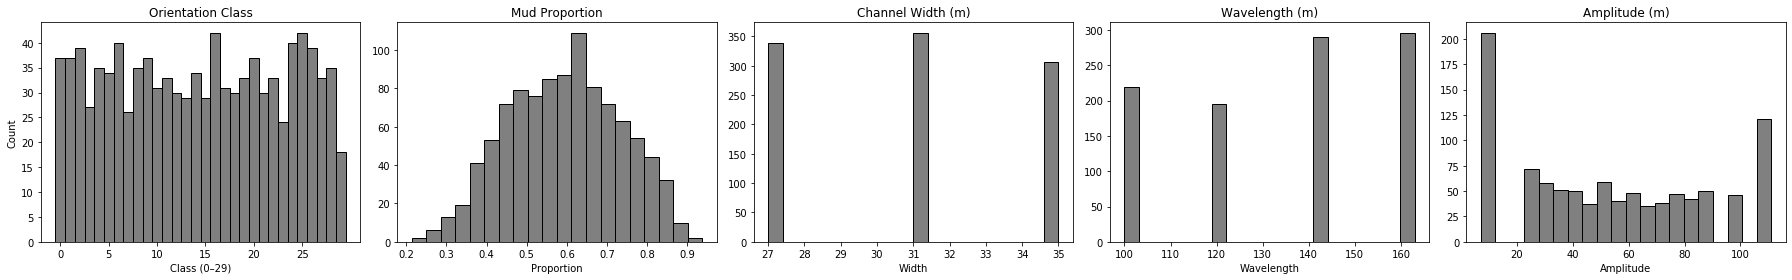

In [6]:
# Create 1-row, 5-column subplot layout
fig, ax = plt.subplots(1, 5, figsize=(25, 4))
plt.subplots_adjust(wspace=0.4)

# Plot orientation class histogram
ax[0].hist(orit_class, bins=np.arange(31)-0.5, color='gray', edgecolor='black')
ax[0].set_title('Orientation Class')
ax[0].set_xlabel('Class (0–29)')
ax[0].set_ylabel('Count')
ax[0].set_xticks(np.arange(0, 30, 5))

# Plot mud proportion histogram
ax[1].hist(mudprop, bins=20, color='gray', edgecolor='black')
ax[1].set_title('Mud Proportion')
ax[1].set_xlabel('Proportion')

# Plot width histogram
ax[2].hist(width, bins=20, color='gray', edgecolor='black')
ax[2].set_title('Channel Width (m)')
ax[2].set_xlabel('Width')

# Plot wavelength histogram
ax[3].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[3].set_title('Wavelength (m)')
ax[3].set_xlabel('Wavelength')

# Plot amplitude histogram
ax[4].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[4].set_title('Amplitude (m)')
ax[4].set_xlabel('Amplitude')

plt.tight_layout()
plt.show()


### 2. Preparing dataset of a test case

**Based on a test case, construct/obtain its conditioning global features, well facies data, and probability maps**

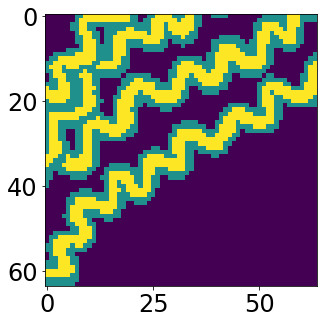

In [7]:
test_num = 1
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5, forward=True)
ax.imshow(facies_test[1,0,:,:])

#plt.savefig(GANSim_dir + "Case1_ground_truth.png", dpi=200) 

In [8]:
# global feature values

print(orit_class[test_num])
print(mudprop[test_num])
print(width[test_num])
print(wvl[test_num])
print(amplt[test_num])

23
0.55563414
31.0
100.0
71.0


In [9]:
# Generate complex random well facies points for conditioning

well_points_test_illu = np.zeros((1, 1, 64, 64), dtype = np.int8)
ssd = 1
for i in range(well_points_test_illu.shape[0]):
    well_points_num = np.random.RandomState(3 * ssd + ssd * ssd).choice(np.arange(1, 11), 1)[0]  # Random choose the expected total number of well points
    # Randomly select well x and y coordinates
    xs = np.random.RandomState(123 * ssd).choice(facies_test.shape[2], well_points_num)
    ys = np.random.RandomState(3 * ssd + ssd * ssd).choice(facies_test.shape[3], well_points_num)
    well_points_test_illu[i, 0, xs, ys] = 1
    
well_facies_test_illu = facies_test[test_num:test_num+1] * well_points_test_illu
well_facies_test_illu = well_facies_test_illu + well_points_test_illu
print(well_facies_test_illu.shape)

wellfaciesimgs_test_loc_illu = np.where(well_facies_test_illu>0, 1, 0)
wellfaciesimgs_test_fc_illu = (well_facies_test_illu - 1) * wellfaciesimgs_test_loc_illu
wellfaciesimgs_test_G_illu = np.concatenate([wellfaciesimgs_test_loc_illu, wellfaciesimgs_test_fc_illu], axis = 1)
print(wellfaciesimgs_test_G_illu.shape)

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,2,2], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel_illu = enlarge(well_facies_test_illu)
wellfacies_onechannel_mask_illu = np.ma.masked_where(wellfacies_onechannel_illu == 0, wellfacies_onechannel_illu)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

(1, 1, 64, 64)
(1, 2, 64, 64)


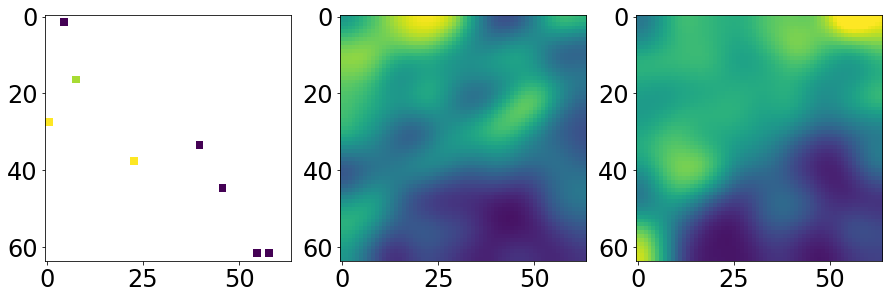

In [10]:
# Well facies data and probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5, forward=True)

ax[0].imshow(wellfacies_onechannel_mask_illu[0,0], cmap=cmap_well, vmax = 2.15)
ax[1].imshow(probimgs_test[test_num, 0].astype(np.float32), vmin = 0, vmax = 0.5)
ax[2].imshow(probimgs_test[test_num, 1].astype(np.float32), vmin = 0, vmax = 0.5)

#plt.savefig(GANSim_dir + "Case1_well_prob.png", dpi=200) 


### 3. Simulation with Petrel-embedded SNESIM MPS algorithm

*Save conditioning data for SNESIM simulation in Petrel*

In [11]:
well_cond_case1 = wellfaciesimgs_test_G_illu[0, 0] + wellfaciesimgs_test_G_illu[0, 1]
well_cond_case1 = np.where(well_cond_case1 < 1, -99, well_cond_case1 - 1)

# Concatenate the arrays along axis 1
condition_data_case1 = np.concatenate((well_cond_case1.reshape(-1, 1), 
                                       probimgs_test[test_num, 0].reshape(-1, 1), 
                                       probimgs_test[test_num, 1].reshape(-1, 1)), axis=1)

# Export the data to a CSV file 
#np.savetxt('/scratch/users/suihong/GenerativeGeomodelling_MPS/PointBar/conditioning_data_case1', condition_data_case1, delimiter=' ', fmt=['%d', '%.6f', '%.6f', '%.6f'])


*After simulation with Petrel, load the simulated facies models to visualize and compare with GANSim results*

In [12]:
# path of SNESMI results
Filepath = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/MPS_cond_gf_well_prob/Conditional_realizations_case1'

allele=[]  # store all elements of the file. including 64*64 lists, and each list includes code for all realizations
with open (Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:            
            allele.append(eles)

mps_results=np.array(allele, dtype=np.float32).reshape(64, 64, -1).astype(np.int32)  # all imges (realizations), of shape (64,64, rlz_no)
mps_results = np.where(mps_results == 1, 4, mps_results)/2 # exchange code of levee and channels
mps_results = mps_results[::-1,:,:]

print(mps_results.shape)

(64, 64, 100)


In [13]:
## check well conditioning effect:

well_cond_check = np.sum(((mps_results - wellfaciesimgs_test_G_illu[0, 1][:, :, np.newaxis]) 
                        * wellfaciesimgs_test_G_illu[0, 0][:, :, np.newaxis])**2)

print(well_cond_check)
# 0 means 100% reproduction accuracy

0.0


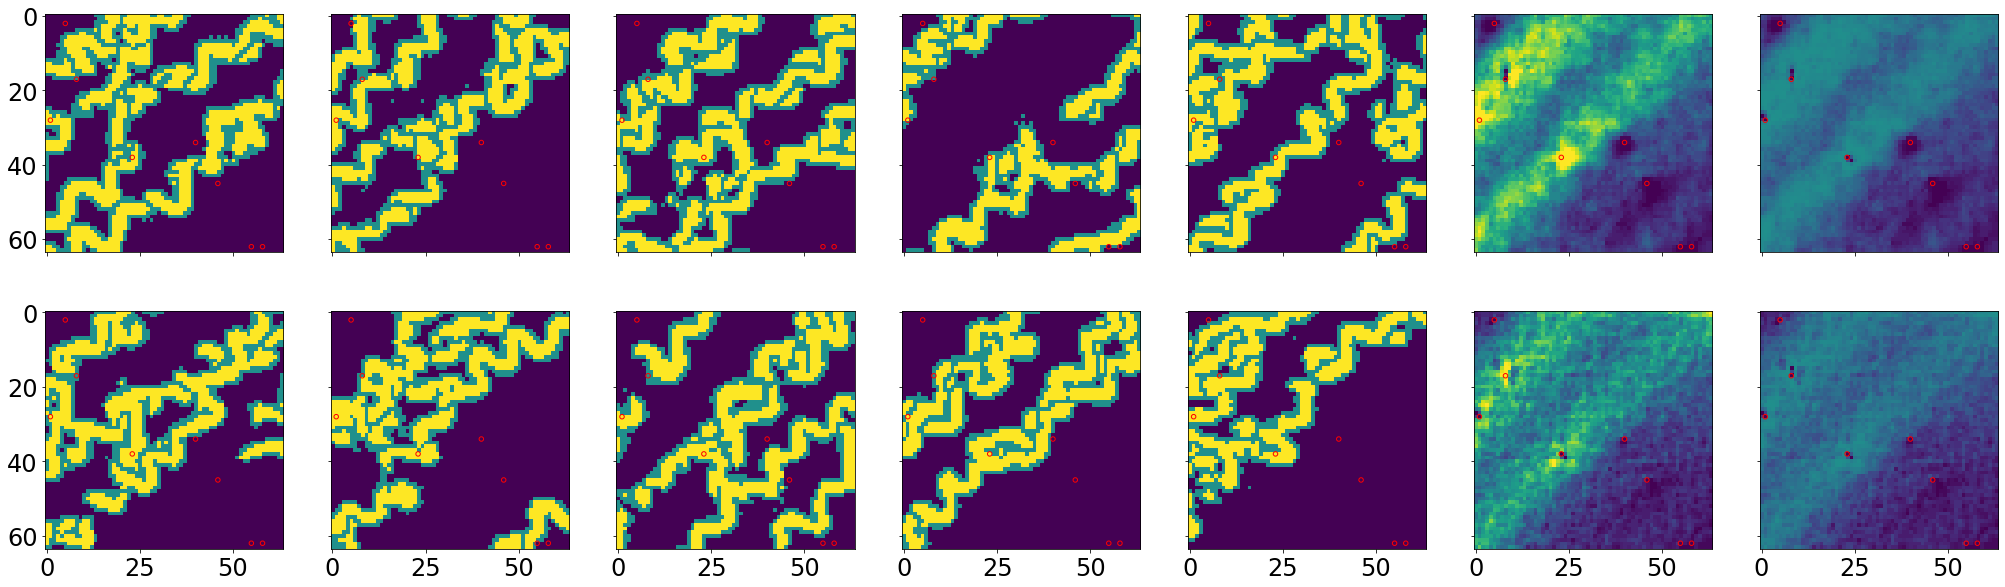

In [14]:
# Several realizations and mean and std

freq_ch_center = np.mean(np.where(mps_results == 2, 1, 0), axis = 2)
var_ch_center = np.var(np.where(mps_results == 2, 1, 0), axis = 2)
freq_ch_levee = np.mean(np.where(mps_results == 1, 1, 0), axis = 2)
var_ch_levee = np.var(np.where(mps_results == 1, 1, 0), axis = 2)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(2, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 10, forward=True)
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(mps_results[:, :, i*5+j+10])
ax[0, 5].imshow(freq_ch_center, vmin = 0, vmax = 0.5) 
ax[0, 6].imshow(var_ch_center, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(freq_ch_levee, vmin = 0, vmax = 0.5) 
ax[1, 6].imshow(var_ch_levee, vmin = 0, vmax = 0.5) 

index_x=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 1]
index_y=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 0]
for i in range(2):
    for j in range(7):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

#plt.savefig('/scratch/users/suihong/GenerativeGeomodelling_MPS/2D_channels/Cond_realizations_freq_case1', dpi=200) 

### 4. Train and simulation with trained conditional generator

#### (1) Load trained generator

In [15]:
GANSim_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/GANSim_cond_gf_well_prob/LatentVector4/'
GANSim_name = 'network-snapshot-016960.pkl'   # 13440

recognizer_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FeatureRecognizer/'
recognizer_name = 'network-snapshot-069520.pkl' 

# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import trained generator networks.
    with open(GANSim_dir + GANSim_name, 'rb') as file:
        G, D, Gs = pickle.load(file)

    # Import trained global feature recognizer
    with open(recognizer_dir + recognizer_name, 'rb') as file:
        _, R, _ = pickle.load(file)        

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [16]:
print(Gs.input_shapes)

print(Gs.output_shapes)

[[None, 8, 4, 4], [None, 34, 64, 64], [None, 2, 64, 64], [None, 2, 64, 64]]
[[None, 3, 64, 64]]


#### (2) Generate facies geomodels for the test case based on given conditioning data

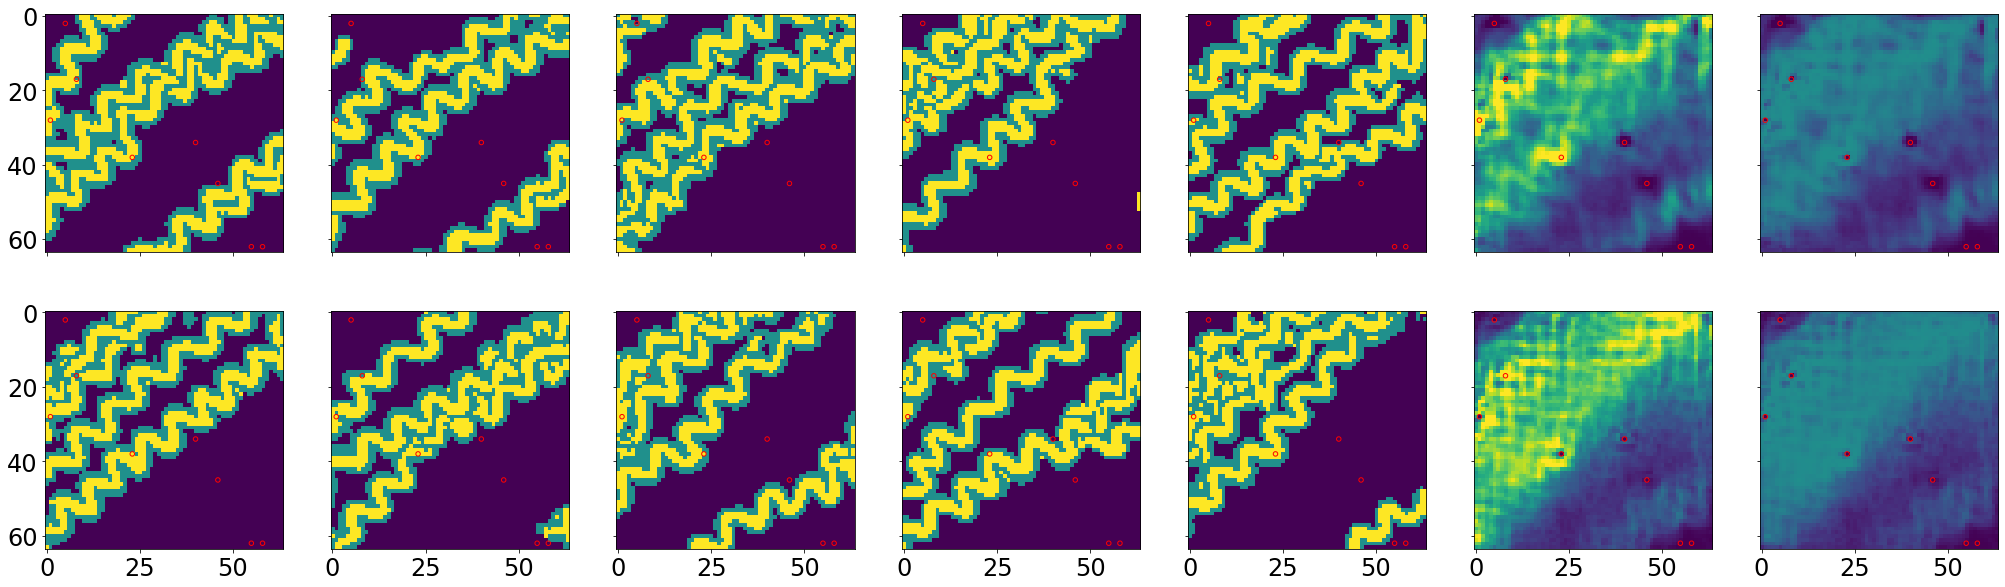

In [17]:
# Several realizations and mean and std

real_num = 1000
latents_plt = np.random.RandomState(410).randn(real_num, Gs.input_shapes[0][1], Gs.input_shapes[0][2], Gs.input_shapes[0][3])
labels_plt = np.tile(np.expand_dims(np.expand_dims(labels_test[test_num:test_num+1], axis = -1), axis = -1), (real_num, 1, 64, 64))  #
wellfacies_plt = np.repeat(np.expand_dims(wellfaciesimgs_test_G_illu[0], axis=0), real_num, axis=0)
prob_plt = np.repeat(probimgs_test[test_num:test_num+1], real_num, axis=0)
 
fakemodel_indicators_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)
    
fakemodel_freq_ch = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_var_ch = np.var(fakemodel_indicators_plt[:, 2], axis = 0)   
fakemodel_freq_bk = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_var_bk = np.var(fakemodel_indicators_plt[:, 1], axis = 0)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(2, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 10, forward=True)
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(fakemodels_plt[i*5+j+10, 0])
ax[0, 5].imshow(fakemodel_freq_ch, vmin = 0, vmax = 0.5) 
ax[0, 6].imshow(fakemodel_var_ch, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(fakemodel_freq_bk, vmin = 0, vmax = 0.5) 
ax[1, 6].imshow(fakemodel_var_bk, vmin = 0, vmax = 0.5) 

index_x=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 1]
index_y=np.argwhere(wellfaciesimgs_test_G_illu[0, 0]>0)[:, 0]
for i in range(2):
    for j in range(7):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

#plt.savefig(GANSim_dir + "Case1_realizations.png", dpi=200) 

#### (3) Evaluate global features of the predicted facies models

In [18]:
# global features of the GANSim results

wellfacies_cond_sim = np.zeros([real_num, 0, 64, 64])
labels_cond_R = R.run(fakemodels_plt, wellfacies_cond_sim)[-1]
    
orit_one_hot_cond_R = labels_cond_R[:, :30]
orit_class_cond_R = np.argmax(orit_one_hot_cond_R, axis = 1)  #

mudprop_cond = np.mean(np.where(fakemodels_plt==0, 1, 0), axis = (1, 2, 3))

wid_cond_R = labels_cond_R[:, 31]  # width after normalization
wid_cond_R = np.where(wid_cond_R < -0.5, -1, np.where(wid_cond_R > 0.5, 1, 0)) 
wid_cond_R = (wid_cond_R / 2 + 0.5) * 8 + 27

wvl_cond_R = labels_cond_R[:, 32]  # width after normalization
wvl_cond_R = np.where(wvl_cond_R < -0.5, -1, np.where(wvl_cond_R < 0., -0.33, np.where(wvl_cond_R > 0.5, 1, 0.3))) 
wvl_cond_R = np.round((wvl_cond_R / 2 + 0.5) * 63 + 100)

amplt_cond_R = labels_cond_R[:, 33] 
amplt_cond_R = (amplt_cond_R / 2 + 0.5) * 104 + 7

In [19]:
# mud proportion feature of SNESIM results

mudprop_snesim = np.mean(np.where(mps_results==0, 1, 0), axis = (0, 1))

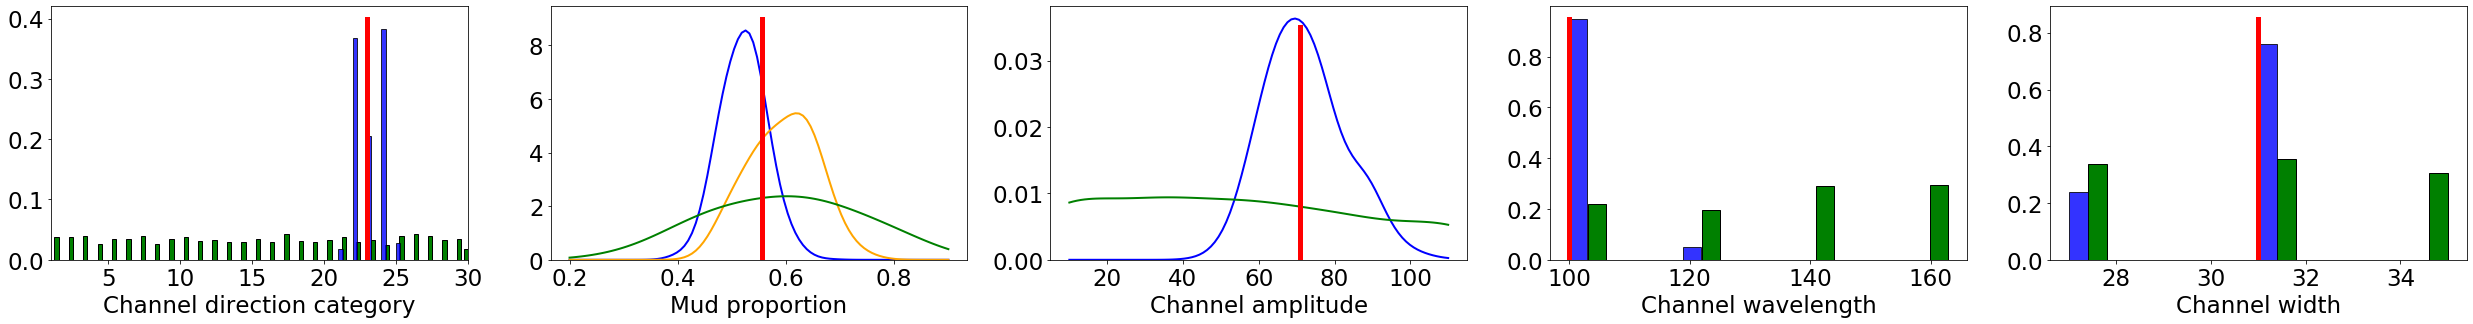

In [20]:
plt.rcParams.update({'font.size': 23})

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(35, 5)

# Plot the histograms for orit_class_cond_R, orit_class_mcmc_R, and orit_class
barwidth = 0.3  # Width for each bar
bin_edges = np.arange(1, 30.5, 0.5)
#ax[0].hist(orit_class_cond_R, bins=bin_edges, alpha=0.5, histtype='bar', ec='black', color='blue', label='cond', density=True, width=barwidth, align='left')  
#ax[0].hist(orit_class_mcmc_R, bins=bin_edges, alpha=0.5, histtype='bar', ec='black', color='orange', label='mcmc', density=True, width=barwidth, align='mid')  
#ax[0].hist((orit_class+1), bins=bin_edges, alpha=1.0, histtype='bar', ec='black', color='green', label='orit_class', density=True, width=barwidth, align='right')  

arr = (orit_class+1)
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[0].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = orit_class_cond_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[0].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
ax[0].plot([orit_class[test_num], orit_class[test_num]], [0, 0.4], 'r-', linewidth=5)  # Reference vertical line (normalized y-axis)
ax[0].set_xlim(left=1, right = 30)
ax[0].set_xlabel('Channel direction category')

from scipy.stats import gaussian_kde
x_range = np.linspace(0.2, 0.9, 100)  # Generate range of values for x-axis
kde_cond = gaussian_kde(mudprop_cond, bw_method=0.5)
pdf_values_cond = kde_cond(x_range)  # Compute PDF values for the range
kde_snesim = gaussian_kde(mudprop_snesim, bw_method=0.5)
pdf_values_snesim = kde_snesim(x_range)  # Compute PDF values for the range
kde = gaussian_kde(mudprop, bw_method=0.5)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values_cond, 'blue', linewidth=2, label='cond PDF')  # Plot PDF for mudprop_cond_R
ax[1].plot(x_range, pdf_values_snesim, 'orange', linewidth=2, label='snesim PDF')  # Plot PDF for mudprop_mcmc_R
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='mudprop PDF')  # Plot PDF for mudprop
ax[1].plot([mudprop[test_num], mudprop[test_num]], [0, 9], 'r-', linewidth=5)  # Increase linewidth for a bolder appearance
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel('Mud proportion')

x_range = np.linspace(10, 110, 100)  # Generate range of values for x-axis
kde_cond_R = gaussian_kde(amplt_cond_R, bw_method=0.35)
pdf_values_cond_R = kde_cond_R(x_range)  # Compute PDF values for the range
kde = gaussian_kde(amplt, bw_method=0.35)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[2].plot(x_range, pdf_values_cond_R, 'blue', linewidth=2, label='cond PDF')  # Plot PDF for mudprop_cond_R
ax[2].plot(x_range, pdf_values, 'g', linewidth=2, label='mudprop PDF')  # Plot PDF for mudprop
ax[2].plot([amplt[test_num], amplt[test_num]], [0, 0.035], 'r-', linewidth=5)  # Increase linewidth for a bolder appearance
ax[2].set_ylim(bottom=0)
ax[2].set_xlabel('Channel amplitude')

barwidth = 3  # Width for each bar
bin_edges = [100. , 106.3, 112.6, 118.9, 125.2, 131.5, 137.8, 144.1, 150.4, 156.7, 163. ]
arr = wvl
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[3].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = wvl_cond_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[3].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
ax[3].plot([wvl[test_num], wvl[test_num]], [0, 0.95], 'r-', linewidth=5)  # Reference vertical line (normalized y-axis)
ax[3].set_xlabel('Channel wavelength')

# Plot the histograms for wid_cond_R, wid_mcmc_R, and width
bin_edges = [27. , 27.8, 28.6, 29.4, 30.2, 31. , 31.8, 32.6, 33.4, 34.2, 35. ]
barwidth = 0.4
arr = width
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[4].bar((edges[0:-1] + edges[1:])/2, samp, width=barwidth, alpha=1., edgecolor='black', color='green', label='test', align='edge')
arr = wid_cond_R
arr_hist , edges = np.histogram(arr, bins=bin_edges)
samp = arr_hist / (arr.shape[0])
ax[4].bar(edges[0:-1], samp, width=barwidth, alpha=0.8, edgecolor='black', color='blue', label='cond',align='edge')
ax[4].plot([width[test_num], width[test_num]], [0, 0.85], 'r-', linewidth=5)  # Reference vertical line (normalized y-axis)
ax[4].set_xlabel('Channel width')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
#plt.savefig(GANSim_dir + "Case1_GlobalFeatures_histograms.png", dpi=100)



#### (4) Gradually changing input global feature value

In [21]:
# --- Varying input amplitude to Generate Realizations ---

# Number of realizations to generate
real_num_tran = 6

# Original test amplitude (raw, before normalization)
amplt_raw = amplt[test_num]
# Generate 6 amplitude values from -90% to +30% of the original test amplitude
amplt_varied_raw = np.linspace(0.1 * amplt_raw, 1.3 * amplt_raw, real_num_tran)
# Normalize amplitude values into the range of [-1, 1]
amplt_varied_norm = ((amplt_varied_raw - 7) / 104 - 0.5) * 2

# Get the test features (normalized); shape of [6, 2]
labels_plt_tran = np.tile(labels_test[test_num:test_num+1], (real_num_tran, 1))
# Replace with the normalized gradually changing amplitude values
labels_plt_tran[:, 33] = amplt_varied_norm
# Expand to shape [real_num, 2, 64, 64]
labels_plt_tran = labels_plt_tran[:, :, np.newaxis, np.newaxis]
labels_plt_tran = np.tile(labels_plt_tran, (1, 1, 64, 64))

# Fixed latent cube (same for all realizations)
np.random.seed(81)
latents_plt_tran = np.random.randn(8, 4, 4)
latents_plt_tran = np.tile(latents_plt_tran[np.newaxis, ...], (real_num_tran, 1, 1, 1))  # shape: (6, 8, 4, 4)

# Repeat well facies and probability maps 6 times
wellfacies_plt_tran = np.repeat(wellfaciesimgs_test_G_illu, real_num_tran, axis=0)
prob_plt_tran = np.repeat(probimgs_test[test_num:test_num+1], real_num_tran, axis=0)

# Run generator
fakemodel_indicators_plt_tran = Gs.run(latents_plt_tran, labels_plt_tran, wellfacies_plt_tran, prob_plt_tran)
fakemodels_plt_tran = np.expand_dims(np.argmax(fakemodel_indicators_plt_tran, axis=1), axis=1)


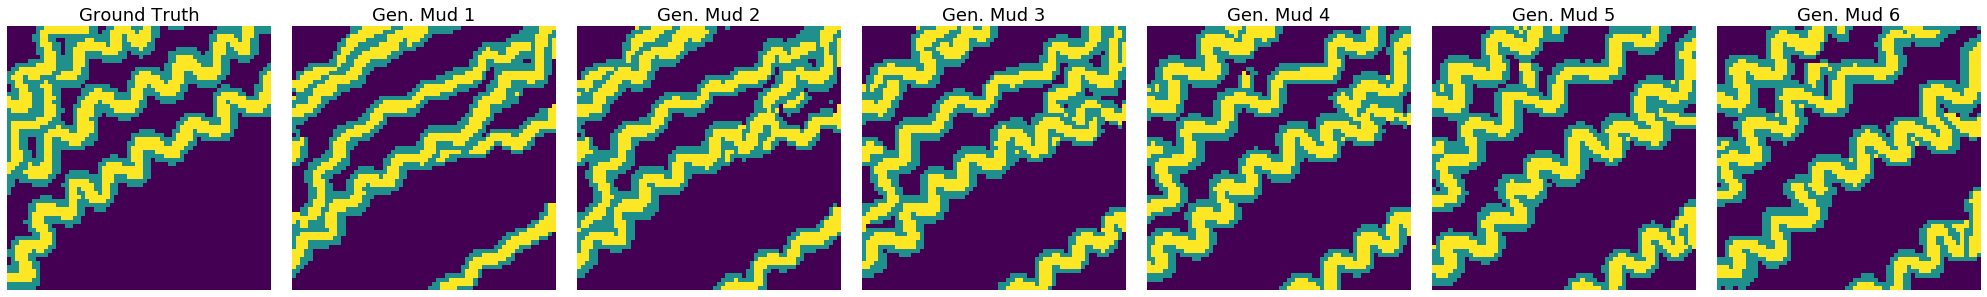

In [22]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 7, figsize=(28, 5))

# Plot ground truth facies map
axs[0].imshow(facies_test[test_num, 0])
axs[0].set_title("Ground Truth", fontsize=18)
axs[0].axis('off')

# Plot 6 generated facies maps
for i in range(6):
    axs[i + 1].imshow(fakemodels_plt_tran[i, 0])
    axs[i + 1].set_title(f"Gen. Mud {i+1}", fontsize=18)
    axs[i + 1].axis('off')

plt.tight_layout()
plt.show()

### 5. Comparison of GANSim and SNESIM results based on flow simulation

*Flow simulation is conducted with Eclipse software, thus need to prepare permeability maps in appropriate format for Eclipse*

#### (1) Prepare permeability map files and boundary pressure values for flow simulation with Eclipse

*One ground truth facies model, 100 GANSim-simulated facies model, 100 SNESIM-simulated facies models*

In [23]:
# constructe permeablity maps based on facies maps

mps_results_transposed = mps_results.transpose(2, 0, 1)[:, np.newaxis, :, :]
perm = np.concatenate((facies_test[test_num:test_num + 1], fakemodels_plt[:100], mps_results_transposed))
perm = np.where(perm == 2, 2500, perm)
perm = np.where(perm == 1, 500, perm)
perm = np.where(perm == 0, 10, perm)

In [24]:
perm.shape

(201, 1, 64, 64)

In [25]:
def saveperm(dirpath, name, perm_map):
    text_name = dirpath + name
    perm_map = np.around(perm_map.reshape(-1))
    
    file = open(text_name, 'a')
    s = 'PERMI'+'\n' # Eclipse Keyword 
    file.write(s)
    for i in range(64*64//26):
        s = str(perm_map[i*26:(i+1)*26]).replace('[', ' ').replace(']', ' ')+'\n'
        file.write(s)    
    s = str(perm_map[-14:]).replace('[', ' ').replace(']', ' ')+'\n'    
    file.write(s)
    file.write('/')
    file.close()

In [26]:
# Write perm_maps into file which Eclipse can recognize and use for flow simulation
savedirpath = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FlowSimRelated/LatentVector4/Perm_BoundaryPres/'

for i in range(perm.shape[0]):
    name = 'permmap_'+str(i+1)
    perm_map = perm[i]
    saveperm(savedirpath, name, perm_map)

In [27]:
small_pres_bound = np.zeros((perm.shape[0], 1)) + 250 # as the small pressure boundary and initial pressure map valaue
large_pres_dound = np.zeros((perm.shape[0], 1)) + 300 

press_bound_values = np.concatenate((large_pres_dound, small_pres_bound), axis=1)

press_name = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FlowSimRelated/LatentVector4/Perm_BoundaryPres/PressureBoundaryValues.txt'
np.savetxt(press_name, press_bound_values, fmt="%1.8f ", newline='\n')   

#### (2) Conduct flow simulation with Eclipse

*See 3_4_Codes_for_Flow_Simulation_by_Calling_Eclipse.ipynb for codes of automatically calling Eclipse to do flow simulation for different permeability maps and boundary pressure values.*

#### (3) Import and visualize simulated pressure results from Eclipse

In [30]:
# Import pressure maps
pres_path = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FlowSimRelated/LatentVector4/SimulatedPres/'

pressmaps=np.zeros((201, 30, 64, 64))
s = []
for i in range(1, 202):
    pres_name = pres_path + 'sim_pressuremaps_'+str(i)
    with open(pres_name, 'r') as f:
        for line in f:
            s.append(line.strip().split(' '))
pressmaps = np.array(s).reshape(-1,30,64,64).astype(np.float32)
    
print(pressmaps.shape)

(201, 30, 64, 64)


*Flow simulation results for ground truth facies model*

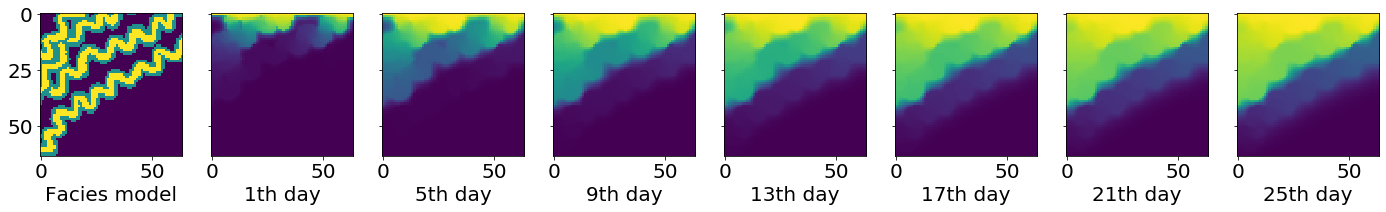

In [31]:
fig, ax = plt.subplots(1, 8, sharex='col', sharey='row')
fig.set_size_inches(24, 4, forward=True)
for i in range(7):
    ax[i + 1].imshow(pressmaps[0, i*4])
    
ax[0].imshow(facies_test[test_num,0,:,:])   

ax[0].set_xlabel('Facies model')           
for i in range(7):
    ax[i + 1].set_xlabel(str(i*4+1) + 'th day')   
# plt.savefig(GANSim_dir + "Case1_Pressmaps_Ref.jpg", dpi=100)

*Flow simulation results for GANSIM-generated facies model*

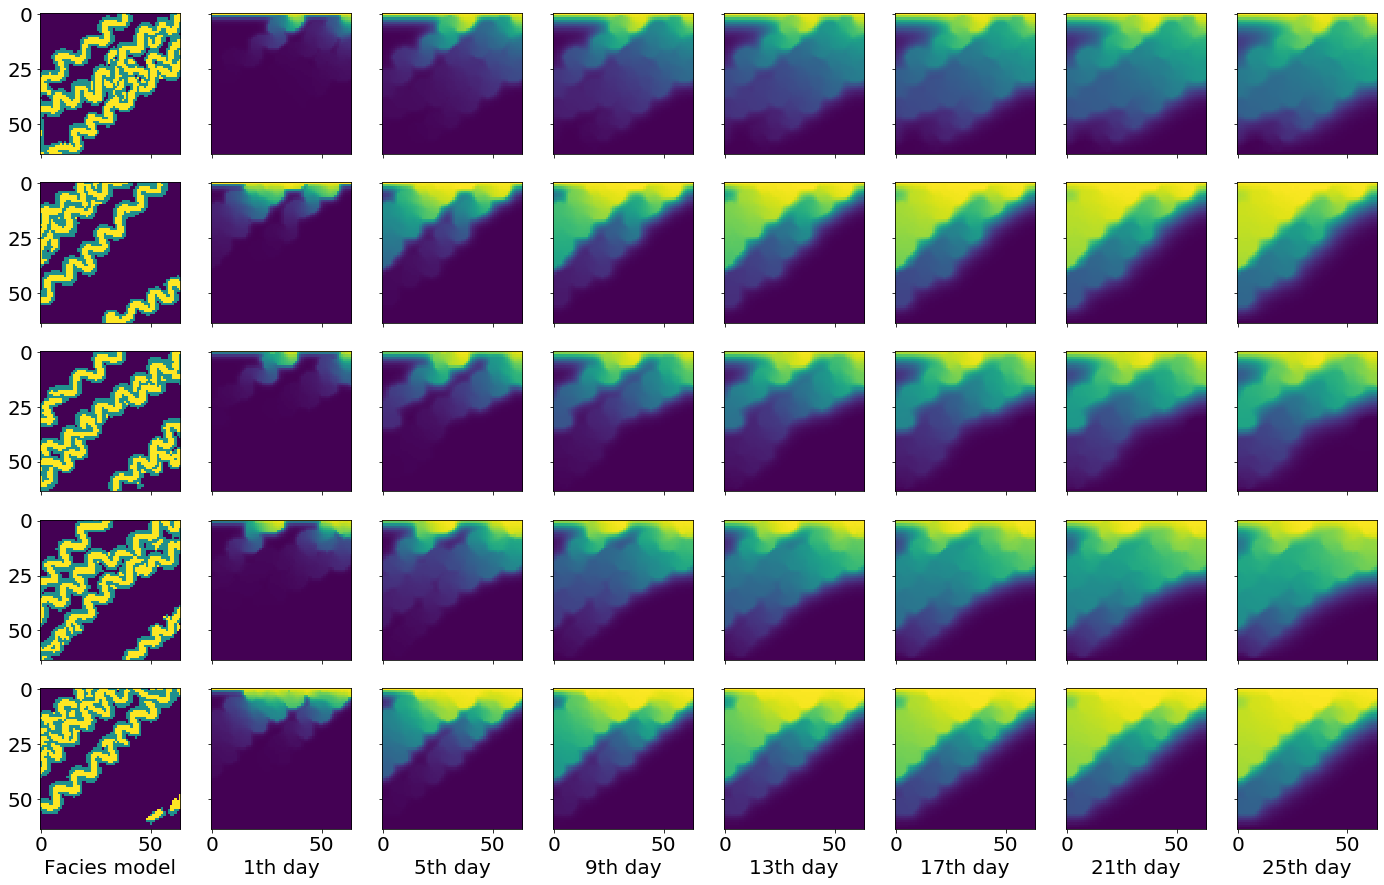

In [32]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 8, sharex='col', sharey='row')
fig.set_size_inches(24, 15, forward=True)
for j in range(5):
    ax[j, 0].imshow(fakemodels_plt[35 + j, 0])
    
    for i in range(7):
        ax[j, i + 1].imshow(pressmaps[1 + 35 + j, i*4])

ax[4, 0].set_xlabel('Facies model')           
for i in range(7):
    ax[4, i + 1].set_xlabel(str(i*4+1) + 'th day')   

#plt.savefig(GANSim_dir + "Case1_Pressmaps_GANSim.jpg", dpi=100)

*Flow simulation results for SNESIM-generated facies model*

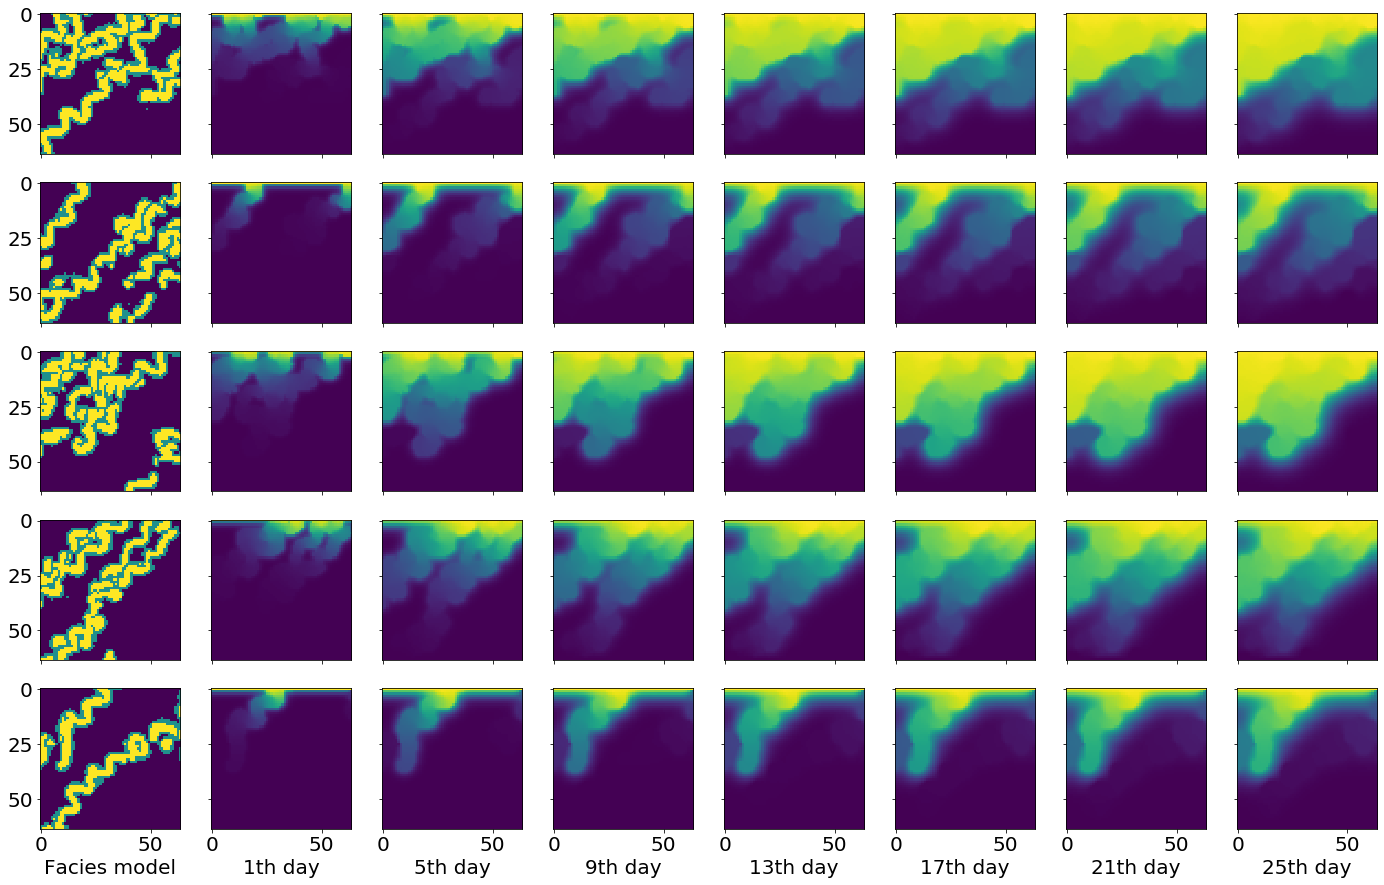

In [34]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 8, sharex='col', sharey='row')
fig.set_size_inches(24, 15, forward=True)
for j in range(5):
    ax[j, 0].imshow(mps_results_transposed[j, 0])
    
    for i in range(7):
        ax[j, i + 1].imshow(pressmaps[101 + j, i*4])

ax[4, 0].set_xlabel('Facies model')           
for i in range(7):
    ax[4, i + 1].set_xlabel(str(i*4+1) + 'th day')   

# plt.savefig(GANSim_dir + "Case1_Pressmaps_SNESIM.jpg", dpi=100)

*Probability maps of being within the flow front, p(pressure>255 bar) on different days after flowing for GANSim and SNESIM*

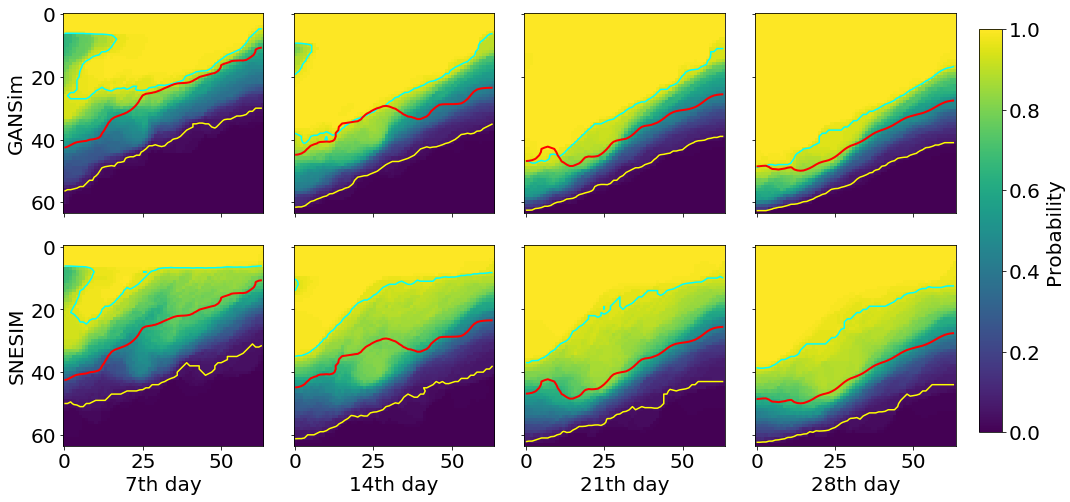

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 20})

# Create figure and axes with black background
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row')
fig.set_size_inches(16, 8, forward=True)
fig.subplots_adjust(hspace=.15, wspace=.15)

pres_front_level = 255

# We will capture the first imshow object to link the colorbar to it
img = None

for i, day in enumerate([6, 13, 20, 27]):
    pressmaps_day_front = np.where(pressmaps[:, day] > pres_front_level, 1, 0)
    pressmaps_day_front_prob_gansim = np.mean(pressmaps_day_front[1:101], axis=0)
    pressmaps_day_front_prob_snesim = np.mean(pressmaps_day_front[101:201], axis=0)

    # GANSim subplot
    img = ax[0, i].imshow(pressmaps_day_front_prob_gansim, vmin=0, vmax=1, cmap='viridis')
    ax[0, i].contour(pressmaps_day_front_prob_gansim, levels=[0.05], colors='yellow', linewidths=1.5)
    ax[0, i].contour(pressmaps_day_front_prob_gansim, levels=[0.95], colors='cyan', linewidths=1.5)
    ax[0, i].contour(pressmaps[0, day], levels=[pres_front_level], colors='red', linewidths=2)

    # SNESIM subplot
    ax[1, i].imshow(pressmaps_day_front_prob_snesim, vmin=0, vmax=1, cmap='viridis')
    ax[1, i].contour(pressmaps_day_front_prob_snesim, levels=[0.05], colors='yellow', linewidths=1.5)
    ax[1, i].contour(pressmaps_day_front_prob_snesim, levels=[0.95], colors='cyan', linewidths=1.5)
    ax[1, i].contour(pressmaps[0, day], levels=[pres_front_level], colors='red', linewidths=2)

    ax[1, i].set_xlabel(str(day + 1) + 'th day')

# Set y-axis labels
ax[0, 0].set_ylabel('GANSim')
ax[1, 0].set_ylabel('SNESIM')

# Add a colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(img, cax=cbar_ax, label='Probability')

# Save the figure if needed
# plt.savefig(GANSim_dir + "Case1_FlowBoundary.png", dpi=100)

plt.show()


### 6. Application of the trained generator for geomodelling of large non-stationary reservoirs

*Generation of facies maps of 128x128*

**Load the large training image**

(1, 1, 128, 128)


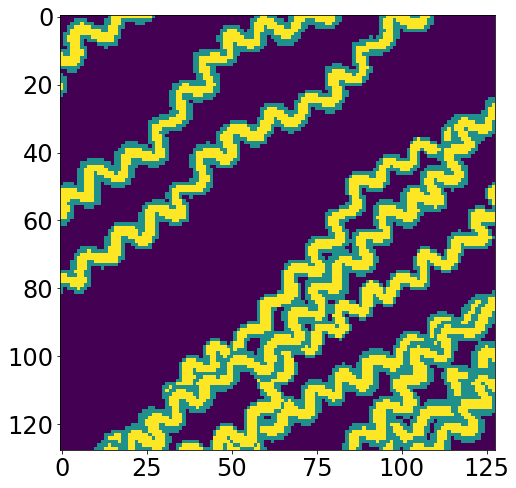

In [36]:
# TI

test_num = 1
resolution_x = 128
resolution_y = 128
TIs_large_load = np.load('/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/TIs_large_npy.npy')
TIs_large_load = TIs_large_load.reshape(-1, 1, 200, 200)

geomodel_large_truth = TIs_large_load[test_num:test_num+1, 0:1, :resolution_x, :resolution_y]

print(geomodel_large_truth.shape)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
fig.set_size_inches(8, 8, forward=True)
ax.imshow(geomodel_large_truth[0,0])

**Prepare facies probability maps**

*Construct a channel density map as the probability map for channel center and channel levee*

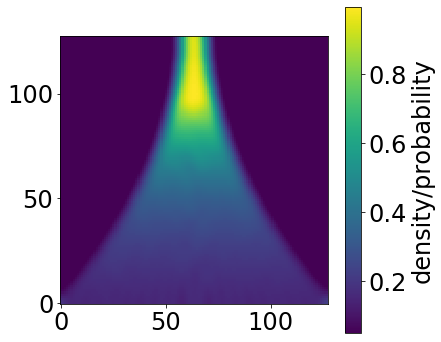

In [37]:
from scipy.ndimage import gaussian_filter

# Map dimensions
height, width = 128, 128
num_curves = 20

# Parameter t for Bézier curve (128 points per curve)
t = np.linspace(0, 1, 128)

# Define start, control, and end points for the curves
start_points = np.linspace(59, 69, num_curves)  # Y-values for starting points
end_points = np.linspace(0, 127, num_curves)  # Y-values for ending points
control_points = np.linspace(56, 72, num_curves)  # Control points for curvature
# Create an empty map
map_128x128 = np.zeros((height, width))

# Generate each curve
for i in range(num_curves):
    x = np.linspace(0, 127, 128).astype(int)
    start_y = start_points[i]
    end_y = end_points[i]
    control_y = control_points[i]
    
    # Quadratic Bézier curve formula
    y = (
        (1 - t)**2 * start_y + 
        2 * (1 - t) * t * control_y + 
        t**2 * end_y
    )
    y = np.clip(y, 0, height - 1).astype(int)  # Ensure valid indices
    
    # Plot each curve onto the map
    for xi, yi in zip(x, y):
        map_128x128[yi, xi] = i + 1  # Mark the curve with incremental values
rotated_map = np.rot90(map_128x128, k=-1)  # k=-1 for clockwise rotation


# --- Step 2: Calculate Gradients and Directions for Each Curve ---
num_curves = 20
directions_map = np.zeros_like(rotated_map, dtype=float)

# Define the curves again (previously calculated x and y coordinates for curves)
# You may already have these from previous code, but I will regenerate the curves here

t = np.linspace(0, 1, 128)  # Parameter t for Bézier curve (128 points per curve)

# Define start, control, and end points for the curves
start_points = np.linspace(59, 69, num_curves)  # Y-values for starting points
end_points = np.linspace(0, 127, num_curves)  # Y-values for ending points
control_points = np.linspace(32, 96, num_curves)  # Control points for curvature

# Generate each curve, calculate direction, and assign to the map
for i in range(num_curves):
    x = np.linspace(0, 127, 128).astype(int)
    start_y = start_points[i]
    end_y = end_points[i]
    control_y = control_points[i]
    
    # Quadratic Bézier curve formula
    y = (
        (1 - t)**2 * start_y + 
        2 * (1 - t) * t * control_y + 
        t**2 * end_y
    )
    y = np.clip(y, 0, 127).astype(int)  # Ensure valid indices
    
    # Calculate the direction of the curve at each point
    # Direction is the angle between two consecutive points
    directions = np.arctan2(np.diff(y), np.diff(x)) * 180 / np.pi  # Calculate angle in degrees
    directions = np.concatenate(([directions[0]], directions))  # Keep the first direction unchanged
    
    # Assign the direction values to the map at corresponding points
    for xi, yi, direction in zip(x, y, directions):
        directions_map[yi, xi] = direction

# --- Step 3: Apply Gaussian Smoothing to Direction Map ---
smoothed_direction_map = gaussian_filter(directions_map, sigma=1)


# --- Step 4: Create and Display Curve Density Map after Gaussian Smoothing ---
# Create a binary curve map (non-zero values represent curves)
binary_map = (rotated_map > 0).astype(float)

# Apply Gaussian smoothing for density
density_map = gaussian_filter(binary_map, sigma=3)
density_map = np.where(density_map < 0.05, 0.05, density_map)
#density_map = np.where((density_map <=0.4) & (density_map>0.1), 0.4, density_map)

# Display Density Map
plt.figure(figsize=(6, 6))
plt.imshow(np.flipud(density_map), origin='lower')
plt.colorbar(label='density/probability')
plt.show()

**Prepare conditioning well facies data from the loaded large training image**

In [38]:
# Generate random well points
geomodel_large_truth_wellpoints = np.zeros(geomodel_large_truth.shape, dtype = np.int8)
for i in range(1):
    well_points_num = 8 #np.random.RandomState(3*i + i*i).choice(np.arange(1, 25), 1)  # Random choose the expected total number of well points
    xs = np.random.RandomState(123*i+123).choice(geomodel_large_truth.shape[2], well_points_num)
    ys = np.random.RandomState(3*i + i*i+111).choice(geomodel_large_truth.shape[3], well_points_num)
    geomodel_large_truth_wellpoints[i, 0, xs, ys] = 1
    
geomodel_large_truth_wellfacies = geomodel_large_truth * geomodel_large_truth_wellpoints

geomodel_large_truth_wellfacies = np.concatenate((geomodel_large_truth_wellpoints, geomodel_large_truth_wellfacies), axis = 1)
geomodel_large_truth_wellfacies = geomodel_large_truth_wellfacies[:, :, :resolution_x, :resolution_y]

print(geomodel_large_truth_wellfacies.shape)


(1, 2, 128, 128)


In [39]:
geomodel_large_truth_wellfacies[:, 1:2] = np.where(density_map>0.15, 2, 0)
geomodel_large_truth_wellfacies[:, 1:2] = geomodel_large_truth_wellfacies[:, 1:2] * geomodel_large_truth_wellfacies[:, 0:1]

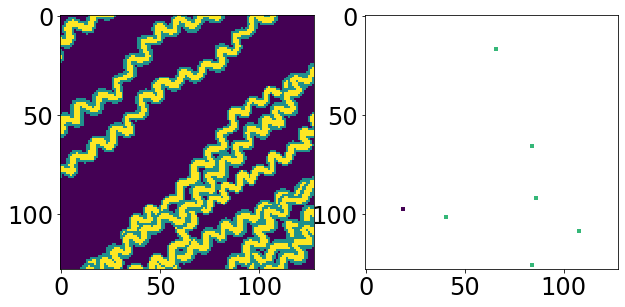

In [40]:
# Only for better visualization of the prepared well facies data

geomodel_large_truth_wellfacies_onechannel = enlarge(geomodel_large_truth_wellfacies[:, 0:1] + geomodel_large_truth_wellfacies[:, 1:2])
geomodel_large_truth_wellfacies_onechannel_mask = np.ma.masked_where(geomodel_large_truth_wellfacies_onechannel == 0, geomodel_large_truth_wellfacies_onechannel)

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)

ax[0].imshow(geomodel_large_truth[0, 0], cmap=cmap_well, vmin = 0, vmax = 2)
ax[1].imshow(geomodel_large_truth_wellfacies_onechannel_mask[0, 0].astype(np.float32), vmin = 1, vmax = 4)


**Prepare conditioning spatially varying channel direction maps**

(1, 1, 128, 128)


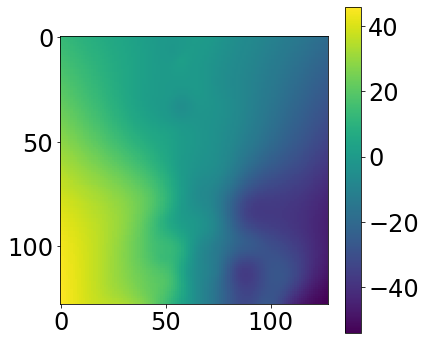

In [44]:
# Load a divergent channel direction file 
saved_dir_map = np.loadtxt('/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/channeldirection.txt')  
saved_dir_map =saved_dir_map.reshape(-1, 1, 200, 200)[:, :, ::-1]
saved_dir_map_large_truth = saved_dir_map[:, :, :resolution_x, int((200 - resolution_y)/2):int((200 - resolution_y)/2) + resolution_y]

print(saved_dir_map_large_truth.shape)

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(6, 6))
plt.imshow(saved_dir_map_large_truth[0,0])
plt.colorbar()

One-hot map shape: (30, 128, 128)


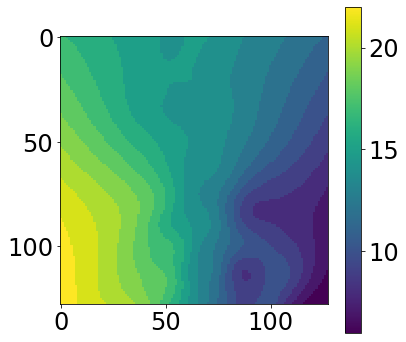

In [45]:
# Function to discretize direction values into categories
def discretize_direction(direction_map, min_angle=-90, max_angle=90, step=6):
    """
    Discretize a continuous direction map into uniform angle bins.

    Parameters:
    - direction_map: numpy array of float values (e.g., -90 to 90 degrees)
    - min_angle: minimum value of direction (default -90)
    - max_angle: maximum value of direction (default 90)
    - step: size of each bin (default 6 degrees)

    Returns:
    - discretized_map: numpy array of int class labels
    """
    # Initialize the discretized output
    discretized_map = np.zeros_like(direction_map, dtype=int)
    
    # Generate bin edges like: [-90, -84), [-84, -78), ...
    bin_edges = np.arange(min_angle, max_angle, step)
    
    for class_id, lower in enumerate(bin_edges):
        upper = lower + step
        # Use open-closed intervals to avoid overlapping
        mask = (direction_map >= lower) & (direction_map < upper)
        discretized_map[mask] = class_id

    # Handle the edge case for max value exactly at +90
    discretized_map[direction_map == max_angle] = len(bin_edges) - 1
    
    return discretized_map


saved_dir_map_large_truth_disc = discretize_direction(saved_dir_map_large_truth)


# Function to convert the discretized map into a one-hot encoded map with desired shape
def to_one_hot_4d(discretized_map, num_classes=30):
    # Create a one-hot encoded map with shape (num_classes, height, width)
    one_hot_map = np.zeros((num_classes, *discretized_map.shape), dtype=int)
    
    # For each pixel, set the corresponding class channel to 1
    for class_id in range(num_classes):
        one_hot_map[class_id] = (discretized_map == class_id).astype(int)
    
    return one_hot_map

# Example usage with a discretized map (replace 'discretized_map' with your actual data)
# Assuming 'discretized_map' has shape (128, 128)
dir_one_hot_map = to_one_hot_4d(saved_dir_map_large_truth_disc[0, 0])

# Check the shape of the result
print("One-hot map shape:", dir_one_hot_map.shape)  # Expected shape: (30, 1, 128, 128)

plt.figure(figsize=(6, 6))
plt.imshow(saved_dir_map_large_truth_disc[0, 0])
plt.colorbar()

#### 6.2. Randomly generate large facies models using GANSim conditioned on these data

*Generation of facies maps of 128x128*

In [46]:
tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
#tf.disable_eager_execution()

import config_large
import tfutil

resolution_x = 128
resolution_y = 128

latent_size_x = int(resolution_x/16)  # 16 is because the original generator enlarges input latent vector size from 4 into output facies model of 64
latent_size_y = int(resolution_y/16)  

Gs_enlarged = tfutil.Network('Gs_enlarged1', 
                             resolution_x = resolution_x, resolution_y = resolution_y,
                             latent_size_x = latent_size_x, latent_size_y = latent_size_y,
                             label_size=config_large.label_size, **config_large.G) 

Gs_enlarged.copy_trainables_from(Gs)
print(Gs_enlarged.input_shapes)
#print(Gs_enlarged.print_layers())

Instructions for updating:
non-resource variables are not supported in the long term
[[Dimension(None), Dimension(8), Dimension(8), Dimension(8)], [Dimension(None), Dimension(34), Dimension(128), Dimension(128)], [Dimension(None), Dimension(2), Dimension(128), Dimension(128)], [Dimension(None), Dimension(2), Dimension(128), Dimension(128)]]


**Generate facies models**

In [47]:
real_num = 100
latents_plt = np.random.RandomState(410).randn(real_num, Gs_enlarged.input_shapes[0][1], Gs_enlarged.input_shapes[0][2], Gs_enlarged.input_shapes[0][3])
labels_plt = np.tile(np.expand_dims(np.expand_dims(labels_test[test_num:test_num+1], axis = -1), axis = -1), (real_num, 1, resolution_x, resolution_y))  #

# set spatially varying global features
labels_plt[:, :30] = np.tile(dir_one_hot_map[np.newaxis, :, :, :], (real_num, 1, 1, 1))  #
labels_plt[:, 30] = np.repeat(1-density_map[np.newaxis, :, :], real_num, axis=0) # mud proportion
labels_plt[:, 31] = np.expand_dims(np.tile(np.linspace(1, -1, 128)[:, np.newaxis], (1, 128)), axis = 0)  # width
labels_plt[:, 32] = np.expand_dims(np.tile(np.linspace(1, 0., 128)[:, np.newaxis], (1, 128)), axis = 0)  # wavelength
labels_plt[:, 33] = np.expand_dims(np.tile(np.linspace(-1, 0., 128)[:, np.newaxis], (1, 128)), axis = 0)  # amplitude

wellfacies_plt = np.repeat(geomodel_large_truth_wellfacies, real_num, axis=0)

# Use well divergent probability maps
prob_plt = np.repeat(np.concatenate((density_map[np.newaxis, np.newaxis, :, :], density_map[np.newaxis, np.newaxis, :, :]), axis = 1), real_num, axis=0)

fakemodel_indicators_plt = Gs_enlarged.run(latents_plt, labels_plt, wellfacies_plt, prob_plt)
fakemodels_plt_lg = np.expand_dims(np.argmax(fakemodel_indicators_plt, axis = 1), axis = 1)
    
fakemodel_freq_ch = np.average(fakemodel_indicators_plt[:, 2], axis = 0)
fakemodel_var_ch = np.var(fakemodel_indicators_plt[:, 2], axis = 0)   
fakemodel_freq_bk = np.average(fakemodel_indicators_plt[:, 1], axis = 0)
fakemodel_var_bk = np.var(fakemodel_indicators_plt[:, 1], axis = 0)


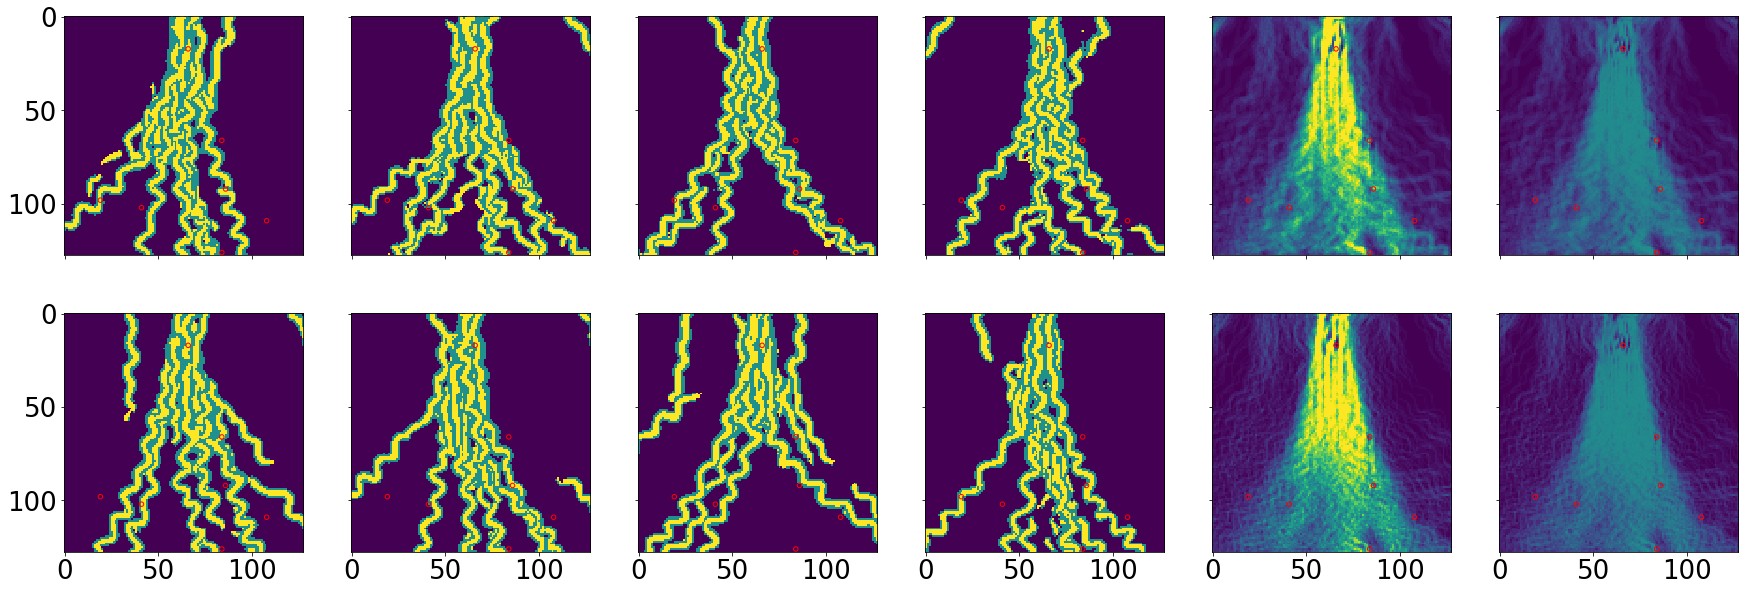

In [48]:
plt.rcParams.update({'font.size': 26})

fig, ax = plt.subplots(2, 6, sharex='col', sharey='row')
fig.set_size_inches(30, 10, forward=True)
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(fakemodels_plt_lg[i*5+j+30, 0])
ax[0, 4].imshow(fakemodel_freq_ch, vmin = 0, vmax = 0.5) 
ax[0, 5].imshow(fakemodel_var_ch, vmin = 0, vmax = 0.5) 
ax[1, 4].imshow(fakemodel_freq_bk, vmin = 0, vmax = 0.5) 
ax[1, 5].imshow(fakemodel_var_bk, vmin = 0, vmax = 0.5) 

#ax[0, 0].imshow(geomodel_large_truth[0, 0]) 

index_x=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 1]
index_y=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 0]
for i in range(2):
    for j in range(6):
        ax[i, j].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')
        
# Save the figure
#plt.savefig(GANSim_dir + "LargeCase_realization.jpg", dpi=100)
        

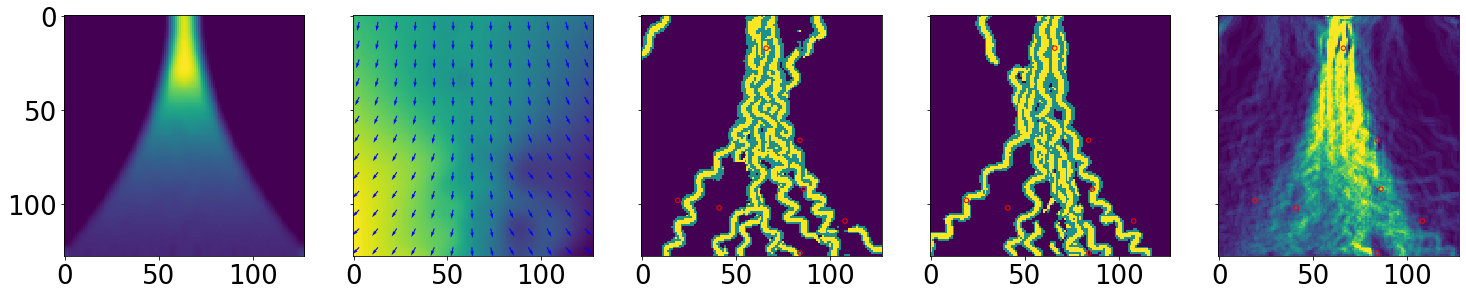

In [49]:
plt.rcParams.update({'font.size': 26})

nx, ny = 128, 128
x, y = np.meshgrid(np.arange(nx), np.arange(ny))

angles_rad = np.deg2rad(saved_dir_map_large_truth[0, 0]+90)  # Convert degrees to radians
# Compute u (x-direction) and v (y-direction) components of the arrows
u = np.cos(angles_rad)
v = np.sin(angles_rad)
# Downsample grid for better visualization (every 8th pixel)
step = 10
x_down, y_down = x[3::step, 3::step], y[3::step, 3::step]
u_down, v_down = u[3::step, 3::step], v[3::step, 3::step]

fig, ax = plt.subplots(1, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 5, forward=True)

ax[0].imshow(density_map)

ax[1].imshow(saved_dir_map_large_truth[0, 0])
#ax.set_xlim(0, 128)
ax[1].invert_yaxis()
ax[1].quiver(x_down, y_down, u_down, v_down, angles='xy', scale_units='xy', scale=0.2, color='b')
#ax[1].axis('equal')  # Ensure square pixels
ax[1].invert_yaxis()
#ax[1].set_xlim(0, 127)

ax[2].imshow(fakemodels_plt_lg[33, 0])
ax[3].imshow(fakemodels_plt_lg[38, 0])
ax[4].imshow(fakemodel_freq_ch, vmin = 0, vmax = 0.5)

index_x=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 1]
index_y=np.argwhere(geomodel_large_truth_wellfacies[0, 0] >0)[:, 0]
for i in range(2, 5):
        ax[i].scatter(index_x, index_y, s=20, marker='o', facecolor='none', edgecolor='red')

# Save the figure
#plt.savefig(GANSim_dir + "LargeCase_conditional_realizations.jpg", dpi=100)




#### !! We found that using a larger input latent vector improves the realism of generated facies models, for the case of generation of large reservoir geomodels. For example, an input latent vector of size 8×8 leads to hidden feature maps of size 16×16 → 32×32 → 64×64, and ultimately outputs a facies map of 64×64 during training, instead of starting with latent vector of 4x4 in this notebook. 

#### !! In our paper, we adopt a larger latent vector of size 8×8 to enable conditioning on global features, well facies, and probability maps. The results and relavent evaluations are in next notebook: 3_3_2_GANSim_condition_to_wellfacies_faciesprob_globalfeatures_Latent8. The GANSim code files for latent vector of 8x8 are in the folder of 3_3_2_GANSimTraining(Latent8). The only changes include settings for the input latent vector size in networks.py, additional convolutional layer in the input pipeline for well facies data in networks.py. 